In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

In [2]:
print(os.getcwd())

c:\Users\Rory\Desktop\projects\expenditure_prox


## Reading in data and preproc

In [3]:
df = pd.read_json('full_data/laptops.json')
df = join_y(df, 'raw_data/laptops_sales.csv')
df = preproc.clean_cols(df)
df = preproc.fill_empty_lists(df)
df = preproc.preprocess_reviews(df)
df = feature_eng.generate_features(df)
df = feature_eng.do_PCA(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df.head(1)

,index,product_name,price,urls,remotekey,shelf_order,item_category,no_reviews,recommendation_percent,review_date,review_rating,review_text,review_title,summary_star_rating,code,TOTAL_SALES,text_preproc,text_preproc2,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,index,c1,c2
0,0,hp 14in ryzen 3 4gb 128gb fhd laptop black,399.99,https://www.argos.co.uk/product/9200856?clickP...,9200856,2,[Includes Microsoft 365 Personal and 1TB OneDr...,17,100,"[30 July 2021, 30 July 2021, 21 July 2021, 8 J...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",[Easy to set up and navigate. Nice and slim an...,"[Love my new HP laptop, Easy to use, Great lap...",4.9,3313337993733739104503754749411541515033011334...,1810,"[[easy, to, set, up, and, navigate, nice, and,...","[[easy, set, navigate, nice, slim, light, carr...",0,17,23.528824,0.17,1.0,0.0,0,-0.120458,-1.31103


# Distributions

ValueError: autodetected range of [0.9926286764705883, inf] is not finite

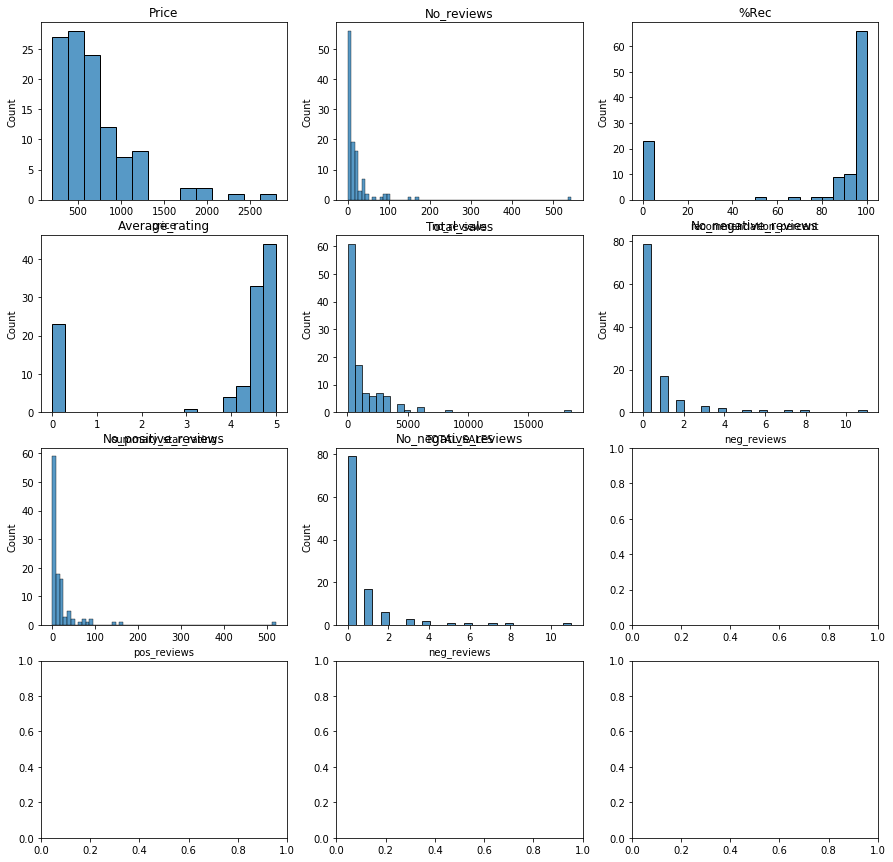

In [6]:
f, axes = plt.subplots(4,3, figsize=(15,15))
sns.histplot(df['price'].dropna(), ax=axes[0,0])
axes[0,0].set_title('Price')
sns.histplot(df['no_reviews'].dropna(), ax=axes[0,1])
axes[0,1].set_title('No_reviews')
sns.histplot(df['recommendation_percent'].dropna(), ax=axes[0,2])
axes[0,2].set_title('%Rec')
sns.histplot(df['summary_star_rating'].dropna(), ax=axes[1,0])
axes[1,0].set_title('Average_rating')
sns.histplot(df['TOTAL_SALES'].dropna(), ax=axes[1,1])
axes[1,1].set_title('Total_sales')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[1,2])
axes[1,2].set_title('No_negative_reviews')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[2,1])
axes[2,1].set_title('No_negative_reviews')
sns.histplot(df['pos_reviews'].dropna(), ax=axes[2,0])
axes[2,0].set_title('No_positive_reviews')
sns.histplot(df['price/Rvol'].dropna(), ax=axes[2,2])
axes[2,2].set_title('price/Rvol')
sns.histplot(df['negR/Rvol'].dropna(), ax=axes[3,0])
axes[3,0].set_title('negR/Rvol')
sns.histplot(df['c1'].dropna(), ax=axes[3,1])
axes[3,1].set_title('PCA_c1')
sns.histplot(df['c2'].dropna(), ax=axes[3,2])
axes[3,2].set_title('PCA_c2')

plt.tight_layout()

## Scaling

In [7]:
# 0 mean variance scaling, keeps NANS
sdf = df.select_dtypes(include=['float','int64'])
sdf['price/Rvol'] = sdf['price/Rvol'].replace(np.inf, sdf['price/Rvol'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])

## Kmeans - PCA

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


(-1, 2)

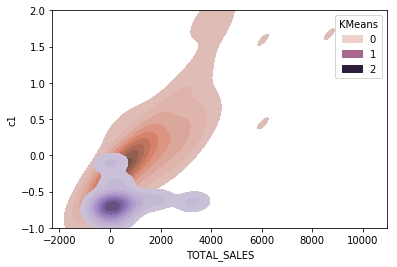

In [9]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,2])

Silhouette score: 0.6761029295887432


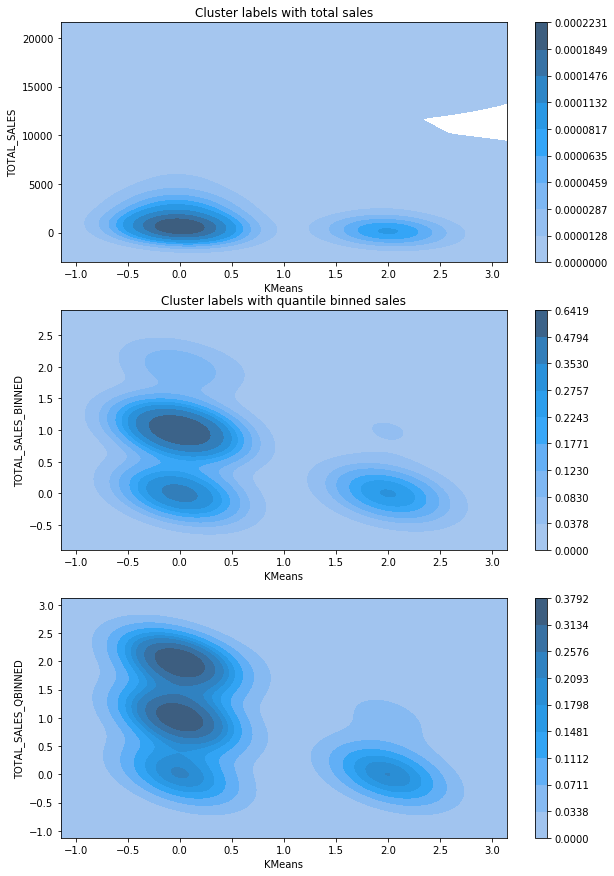

In [10]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

## KMeans - PCA with outliers removal

In [ ]:
df.columns

Index(['index', 'product_name', 'price', 'urls', 'remotekey', 'shelf_order',
       'item_category', 'no_reviews', 'recommendation_percent', 'review_date',
       'review_rating', 'review_text', 'review_title', 'summary_star_rating',
       'code', 'TOTAL_SALES', 'text_preproc', 'text_preproc2', 'neg_reviews',
       'pos_reviews', 'price/Rvol', 'Rvol/%rec', 'posR/Rvol', 'negR/Rvol',
       'index', 'c1', 'c2'],
      dtype='object')

Text(0.5,1,'Z-scores of primary comp')

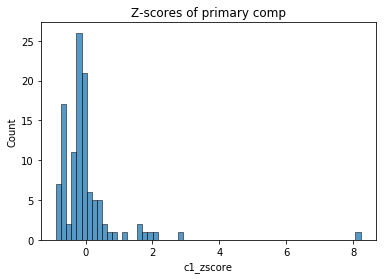

In [11]:
sdf = df.select_dtypes(include=['float','int64'])
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
sdf['c1_zscore'] = (sdf['c1']-sdf['c1'].mean())/sdf['c1'].std()
X = sdf[['c1','c2']]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

Text(0.5,1,'Z-scores of primary comp')

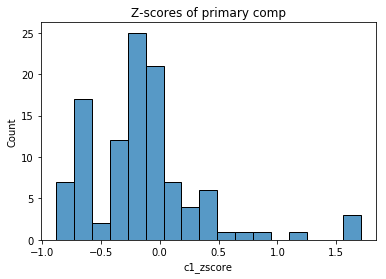

In [13]:
sdf = sdf.loc[sdf['c1_zscore'] <=2]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

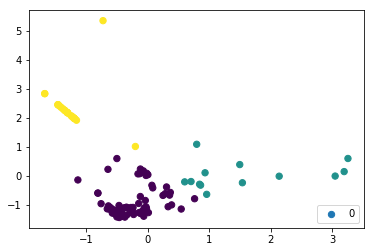

In [14]:
X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)
plt.scatter(X['c1'], X['c2'], c=y_km, s=40, cmap='viridis')
plt.legend(y_km, loc=4)


Silhouette score: 0.6332354813229734


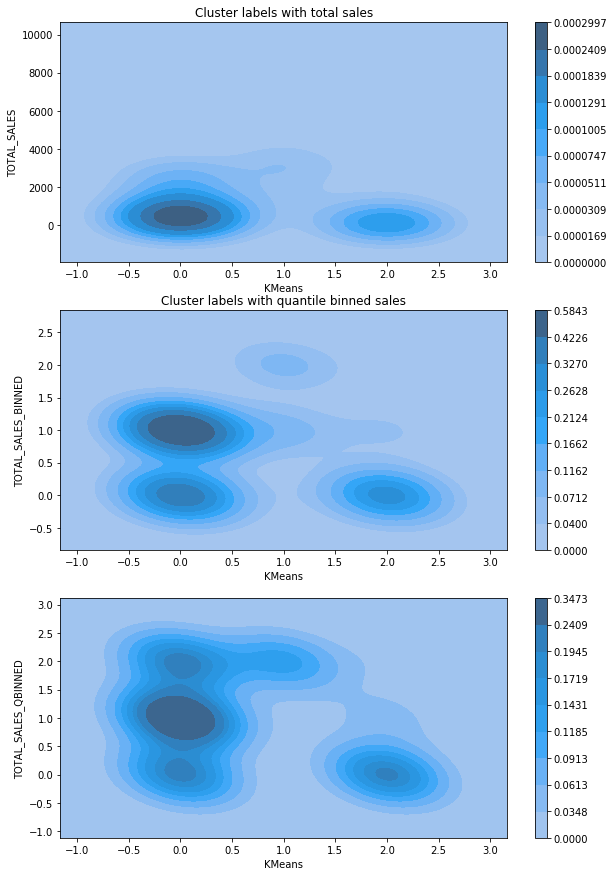

In [15]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

(-1, 2)

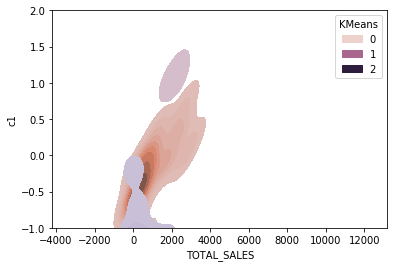

In [16]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,2])

## KMeans - Top 3 features

In [20]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews']]
sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


Silhouette score: 0.8193670620865543


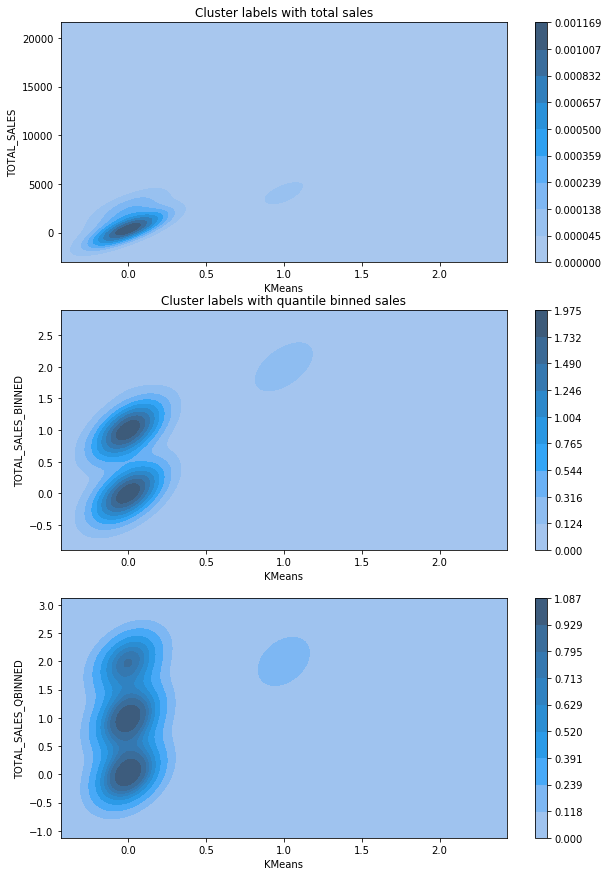

In [21]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'],  sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])


In [22]:
from modules import cluster_intelligence

cluster_intelligence.cluster_report(X, y_km, )

,class_name,instance_count,rule_list
0,0,103,[1.0] (pos_reviews <= -0.20513731241226196)[0.82] (pos_reviews > -0.20513731241226196)
1,1,8,NaN
2,2,1,NaN


## KMeans top 3 features - outliers removed with price

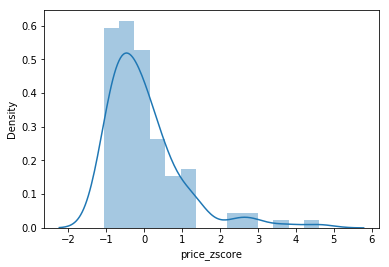

In [29]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews','price']]
sdf['price_zscore'] = (sdf['price']-sdf['price'].mean())/sdf['price'].std()
sns.distplot(sdf['price_zscore'])

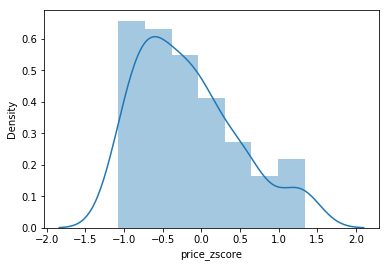

In [30]:
sdf = sdf.loc[(sdf['price_zscore'] >= -2)]
sdf = sdf.loc[(sdf['price_zscore'] <= 2)]
sdf['price_zscore'].max()
sns.distplot(sdf['price_zscore'])

In [31]:

sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,400,3200,20000], labels=[0,1,2])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 3, labels=[0,1,2])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=3, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)

Silhouette score: 0.8134047062042343


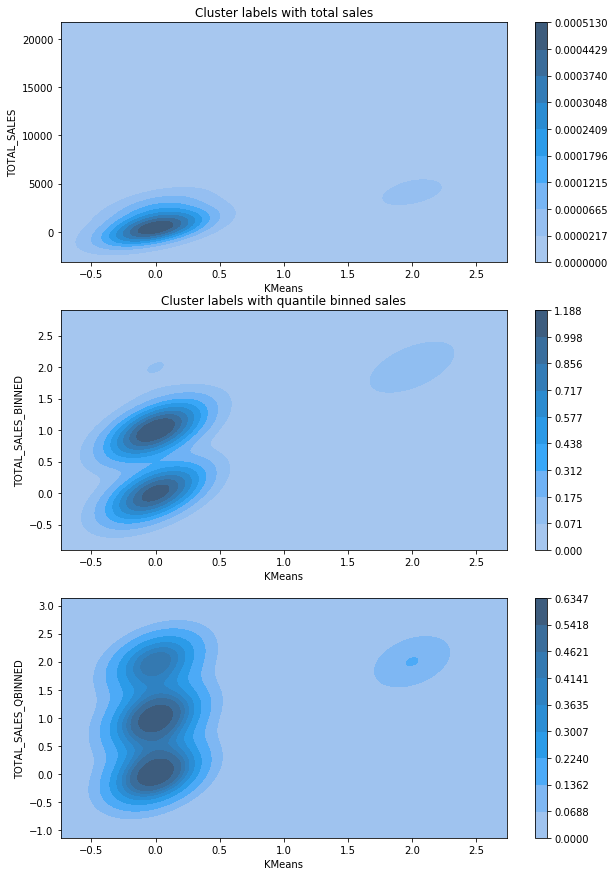

In [32]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [33]:
cluster_intelligence.cluster_report(X, y_km, )

,class_name,instance_count,rule_list
0,0,97,[1.0] (pos_reviews <= -0.2192852944135666)[0.82] (pos_reviews > -0.2192852944135666)
2,1,1,NaN
1,2,8,NaN


## DBscan top3 - outliers removed on price

Silhouette score: 0.8250263541343684


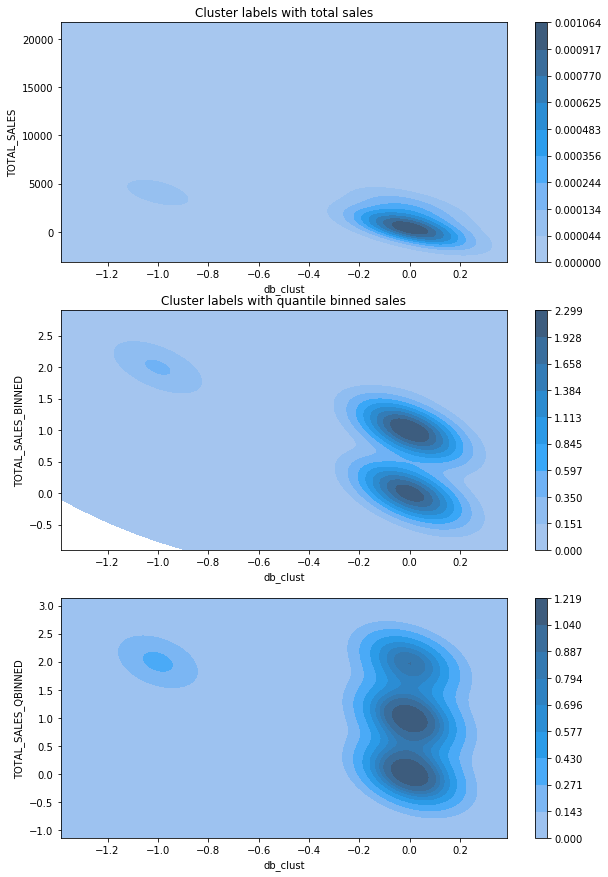

In [35]:
from sklearn.cluster import DBSCAN
from numpy import unique, where
from matplotlib import pyplot

# define the model
dbscan_model = DBSCAN(eps=0.25, min_samples=5)
# train the model
db_clust = dbscan_model.fit_predict(X)
sdf['db_clust'] = pd.Series(db_clust, index=sdf.index)
cluster_intelligence.evaluate_clusters(X, sdf['db_clust'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [36]:
cluster_intelligence.cluster_report(X, db_clust)

,class_name,instance_count,rule_list
1,-1,9,NaN
0,0,97,[1.0] (pos_reviews <= -0.2192852944135666)[0.82] (pos_reviews > -0.2192852944135666)


In [51]:
sdf.loc[sdf.TOTAL_SALES > 4000]

,no_reviews,Rvol/%rec,pos_reviews,price,price_zscore,TOTAL_SALES,TOTAL_SALES_BINNED,TOTAL_SALES_QBINNED,KMeans,db_clust,birch,Ag
7,0.150704,0.110056,0.128576,-1.046853,-1.046853,6051,2,2,0,0,2,0
8,2.495916,2.495856,2.501165,0.377868,0.377868,5038,2,2,2,-1,0,2
19,8.834784,8.862660,8.887534,-0.232727,-0.232727,18554,2,2,1,-1,1,1
20,1.221344,1.213620,1.181078,-1.318228,-1.318228,8686,2,2,2,-1,0,2
93,1.119378,1.178586,1.020526,-0.707634,-0.707634,4311,2,2,2,-1,0,2
97,1.306316,1.282581,1.270273,-1.386072,-1.386072,6067,2,2,2,-1,0,2
98,2.224007,2.218536,2.215741,-1.114697,-1.114697,4158,2,2,2,-1,0,2
108,1.153367,1.357132,0.967009,-0.877243,-0.877243,4126,2,2,2,-1,0,2


In [52]:
sdf.loc[sdf.db_clust == -1]

,no_reviews,Rvol/%rec,pos_reviews,price,price_zscore,TOTAL_SALES,TOTAL_SALES_BINNED,TOTAL_SALES_QBINNED,KMeans,db_clust,birch,Ag
4,0.915447,0.898316,0.877814,-0.538024,-0.538024,3278,2,2,2,-1,0,2
8,2.495916,2.495856,2.501165,0.377868,0.377868,5038,2,2,2,-1,0,2
19,8.834784,8.862660,8.887534,-0.232727,-0.232727,18554,2,2,1,-1,1,1
20,1.221344,1.213620,1.181078,-1.318228,-1.318228,8686,2,2,2,-1,0,2
93,1.119378,1.178586,1.020526,-0.707634,-0.707634,4311,2,2,2,-1,0,2
97,1.306316,1.282581,1.270273,-1.386072,-1.386072,6067,2,2,2,-1,0,2
98,2.224007,2.218536,2.215741,-1.114697,-1.114697,4158,2,2,2,-1,0,2
108,1.153367,1.357132,0.967009,-0.877243,-0.877243,4126,2,2,2,-1,0,2
110,0.745504,0.662988,0.788619,1.324324,1.324324,3055,1,2,2,-1,0,2


*ALL TOP SELLERS APART FROM 1 item are in CLUSTER -1. DBSCAN IS THE ONE LETS GO FROM HERE*.

## Birch top 3 features - outliers removed on price

Silhouette score: 0.8134047062042343


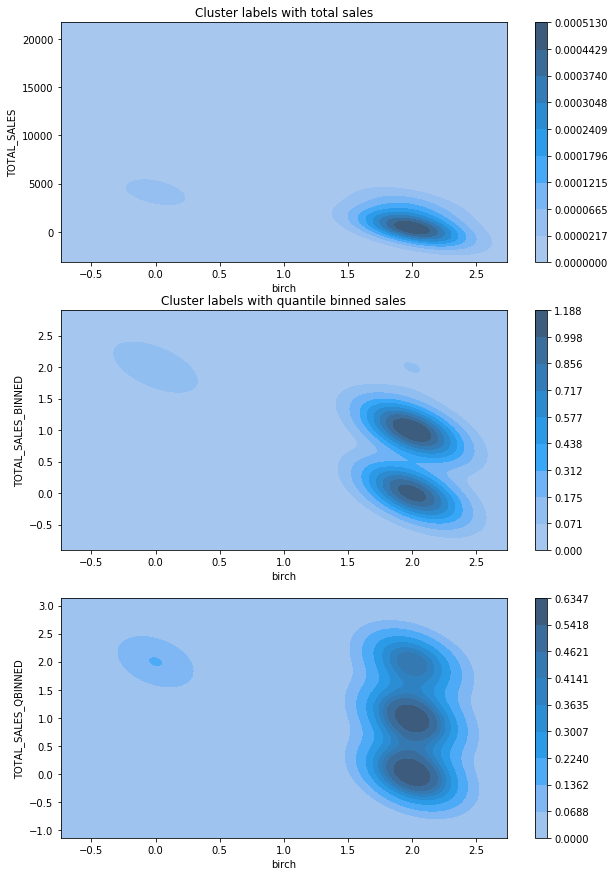

In [39]:
from sklearn.cluster import Birch

birch_model = Birch(threshold=0.03, n_clusters=3)
# train the model
birchy = birch_model.fit_predict(X)
sdf['birch'] = pd.Series(birchy, index=sdf.index)
cluster_intelligence.evaluate_clusters(X, sdf['birch'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [40]:
cluster_intelligence.cluster_report(X, birchy)

,class_name,instance_count,rule_list
1,0,8,NaN
2,1,1,NaN
0,2,97,[1.0] (pos_reviews <= -0.2192852944135666)[0.82] (pos_reviews > -0.2192852944135666)


## Agglomerative clustering top 3 features - outliers removed on price

Silhouette score: 0.8134047062042343


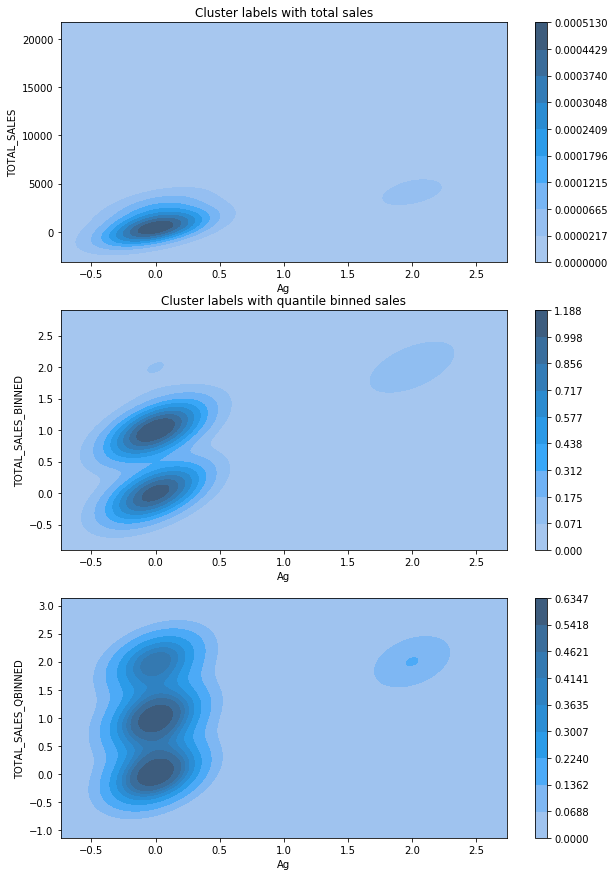

In [43]:
from sklearn.cluster import AgglomerativeClustering
AP =  AgglomerativeClustering(n_clusters=3)
Apm = AP.fit_predict(X)
sdf['Ag'] = pd.Series(Apm, index=sdf.index)
cluster_intelligence.evaluate_clusters(X, sdf['Ag'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [44]:
cluster_intelligence.cluster_report(X, Apm)

,class_name,instance_count,rule_list
0,0,97,[1.0] (pos_reviews <= -0.2192852944135666)[0.82] (pos_reviews > -0.2192852944135666)
2,1,1,NaN
1,2,8,NaN
